## PS2 MLest Assignment
### Chen Anhua
### Q1

#### (a) Percentage histogram

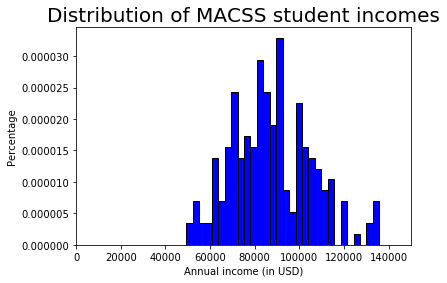

In [2]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

incomes = np.loadtxt('incomes.txt')

count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = "blue", normed=True)
plt.title('Distribution of MACSS student incomes', fontsize=20)
plt.xlabel('Annual income (in USD)')
plt.ylabel('Percentage')
plt.xlim([0, 150000])
plt.show()

#### (b) Lognormal PDF

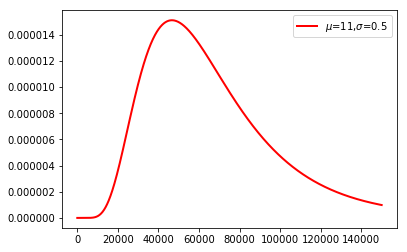

Log-likelihood:  -2385.85699781


In [3]:
# Define the log-normal pdf function
def lognormal_pdf(xvals, mu, sigma):
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

# Define the log likelihood value for this parametrization
def log_lik_lognormal(xvals, mu, sigma):
    pdf_vals = lognormal_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

# plotting the pdf of log normal distribution 
dist_incomes = np.linspace(1e-10, 150000, 1000)    # the grid 
mu_1 = 11.0
sigma_1 = 0.5
plt.plot(dist_incomes, lognormal_pdf(dist_incomes, mu_1, sigma_1),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper right')
plt.show()

# calculating the loglikelihood value
print('Log-likelihood: ', log_lik_lognormal(incomes, mu_1, sigma_1))


#### (c) Parameteres estimation using MLE

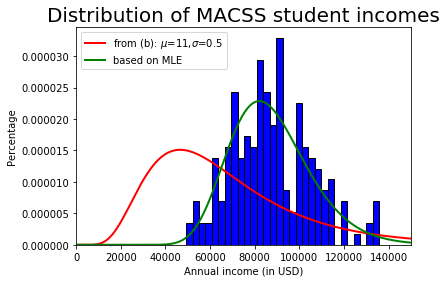

In [4]:
## Define the criteria function
def crit(params, args):
    mu, sigma = params
    xvals = args
    log_lik_val = log_lik_lognormal(xvals, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

mu_init =  11 #np.mean(np.log(incomes))+0.05   # or 
sigma_init = 0.4 # np.std(np.log(incomes))+0.01  # or 
params_init = np.array([mu_init, sigma_init])
mle_args = incomes
bnds = ((1e-1, 1e2), (1e-1, 1e2))
results = opt.minimize(crit, params_init, args=mle_args, 
                       bounds = bnds,
                       method = "L-BFGS-B",
                       tol = 1e-20)
mu_MLE, sigma_MLE = results.x

count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = "blue", normed=True)
plt.title('Distribution of MACSS student incomes', fontsize=20)
plt.xlabel('Annual income (in USD)')
plt.ylabel('Percentage')
plt.xlim([0, 150000])

plt.plot(dist_incomes, lognormal_pdf(dist_incomes, mu_1, sigma_1),
         linewidth=2, color='r', label='from (b): $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

plt.plot(dist_incomes, lognormal_pdf(dist_incomes, mu_MLE, sigma_MLE),
         linewidth=2, color='g', label='based on MLE')
plt.legend(loc='upper left')
plt.show()



In [5]:
print('mu_MLE=', mu_MLE, ' sig_MLE=', sigma_MLE)
print('Function value: ', results.fun)
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print('VCV matrix:')
print(vcv_mle)



mu_MLE= 11.3590229996  sig_MLE= 0.208177322295
Function value:  2241.71930136
VCV matrix:
[[  2.65623673e-04   1.99824074e-06]
 [  1.99824074e-06   1.06051126e-04]]


#### (d) likelihood ratio testing

In [6]:
# get the standard error of mu and sigma
log_lik_h0 = log_lik_lognormal(incomes, 11, 0.5)
log_lik_mle = log_lik_lognormal(incomes, mu_MLE, sigma_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', '{0:.16f}'.format(pval_h0))


chi squared of H0 with 2 degrees of freedom p-value =  0.0000000000000000


According to the extremely small p-value, it seems we could reject null hypothesis that the mu and sigma are 11 and 0.5 respectively

#### (e) model prediction

In [7]:
#Since we are using the same linear discrete grid of dist_incomes, we could just calculate the probability
# based on the sum of pdf estimate for each grid point
prob_less_75000 = (lognormal_pdf(dist_incomes[dist_incomes<75000], mu_MLE, sigma_MLE).sum()/
                   lognormal_pdf(dist_incomes, mu_MLE, sigma_MLE).sum())
prob_more_100000 = (lognormal_pdf(dist_incomes[dist_incomes>100000], mu_MLE, sigma_MLE).sum()/
                   lognormal_pdf(dist_incomes, mu_MLE, sigma_MLE).sum())

print("Probability of earning less than $75000: ",prob_less_75000)
print("Probability of earning more than $100000: ",prob_more_100000)



Probability of earning less than $75000:  0.261168500325
Probability of earning more than $100000:  0.22820034519


### Q2

#### (a)

Because we might run into some numerical instability issue when taking log. Therefore, instead of sum the log of likelihood of 200 observations, I will first analytically simplify the log-likelihood function so that we will take less logs:
Log-likelihood = $-\frac{n}{2}log(2\pi) - nlog(\sigma) - \frac{1}{2\sigma^2}\boldsymbol \epsilon^{T}\boldsymbol\epsilon$

In [8]:
sick = pd.read_csv("sick.txt")
sick.insert(loc = 1, value=1, column="constant")
# Define a new function to derive the error terms
def log_lik_normal_reg(xvals, yvals, betas, sigma):
    n = len(yvals)
    log_lik_val = (     # this function corresponds to the function mentioned above
        (-n / 2) * np.log(2 * np.pi) - 
        (n) * np.log(sigma) - 
        (1 / (2 * sigma ** 2) * (yvals - xvals @ betas).T @ (yvals - xvals @ betas))
    )     
    
    return log_lik_val
    
    
def crit_q2(params, args):
    '''
    '''
    beta0, beta1, beta2, beta3, sigma = params
    betas = np.array([beta0, beta1, beta2, beta3])
    xvals = args.iloc[:, 1:].values
    yvals = args.iloc[:, 0].values
    neg_log_lik_val = -log_lik_normal_reg(xvals, yvals, betas, sigma)
    
    return neg_log_lik_val

In [9]:
params_init = (1, 0 , 0, 0, 0.01)
bnds = ((-1e3, 1e3),(-1e3, 1e3),(-1e3, 1e3),(-1e3, 1e3), (1e-10, None))
results = opt.minimize(crit_q2, params_init, args=sick, 
                       bounds = bnds,
                       method = "L-BFGS-B",
                       tol = 1e-20)
print("Estimates: ", results.x)
print("Log likelihood: ", -results.fun)

Estimates:  [ 0.25164474  0.01293345  0.40050117 -0.0099917   0.00301768]
Log likelihood:  876.865063834


$\beta_{0} = 0.25164491$
$\beta_{1} = 0.0129332$
$\beta_{2} = 0.4005039$
$\beta_{3} = -0.00999162$
$\sigma = 0.00301807$


In [10]:
OffDiagNeg = np.array([[1, -1, -1, -1, -1], 
                       [-1, 1, -1, -1, -1],
                       [-1, -1, 1, -1, -1],
                       [-1, -1, -1, 1, -1],
                       [-1, -1, -1, -1, 1]])
vcv = results.hess_inv.todense() * OffDiagNeg
print("VCV matrix: \n", vcv)


VCV matrix: 
 [[ 0.54719569  0.03820029  0.09455479 -0.03049021 -0.23696745]
 [ 0.03820029  0.01534228  0.02075701  0.01337698 -0.1473912 ]
 [ 0.09455479  0.02075701  0.09977698 -0.01880597  0.41875683]
 [-0.03049021  0.01337698 -0.01880597  0.01168274  0.13207409]
 [-0.23696745 -0.1473912   0.41875683  0.13207409  2.24639329]]


#### (b) Ratio testing

In [11]:
xvals = sick.iloc[:, 1:].values
yvals = sick.iloc[:, 0].values
h0 = log_lik_normal_reg(xvals, yvals, [1,0,0,0], 0.01)
mle = log_lik_normal_reg(xvals, yvals, results.x[:4], results.x[4])
ratio = 2 * (mle - h0)
pval_h0 = 1.0 - sts.chi2.cdf(ratio, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', '{0:.16f}'.format(pval_h0))

chi squared of H0 with 2 degrees of freedom p-value =  0.0000000000000000


Given the small p-value, we will reject null hypothesis